# TP 4 - Deep learning for computer vision

---
This notebook contains the code samples found in Chapter 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

---

Convolutional neural networks are very similar to regular neural networks: they are made up of layers that have trainable parameters. So what does change? ConvNets make the explicit assumption that the inputs are images, which allows them to encode certain properties into the architecture. This makes the forward propagation more efficient to implement and vastly reduce the amount of parameters in the network.

#### Fully-connected layers

Neural networks transform its input data through a series of layers. Each layer is made up of neurons, and each of them is fully connected to all neurons in the previous layer. Due to the high number of neurons and connections, the fully-connected structure clearly does not scale well to images. For example, an image of respectable size, say 200x200x3, would lead to neurons that have 200x200x3 = 120'000 weights. We would almost certainly want to have several such neurons, so the parameters would add up quickly! Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.

![fcn.jpeg](https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0402.png)

#### Convolutional layers

ConvNets take advantage of the fact that the input consists of images, and they constrain the architecture in a more sensible way. To do so, they make use of convolutional layers. The fundamental difference is this: fully-connected layers learn global patterns in the inputs, whereas convolution layers learn local patterns in small 2D windows of the inputs. More specifically, a convolution layer operates over 3D tensors with two spatial axes and a depth axis (height, width, channels). The convolution operation extracts patches from its input, and applies the same transformation to all of these patches. The output is still a 3D tensor, but its dimensions depend on the layer's hyper-parameters, specified by the *kernel size* and the *number of kernels*.

![conv2.jpeg](https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-26-at-1.44.58-PM.png)

#### ConvNet architecture

ConvNets mainly use three types of layers: convolutional (CONV), pooling (POOL), fully-connected (FC). The figure below shows a concrete example of ConvNet architecture. The first layer (left) stores the raw image pixels, whereas and the last layer (right) stores the class probabilities. The activation of each hidden layer along the processing path is shown as a column.

![convnet.jpeg](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)

In [2]:
## Uncomment the following code if you use Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

# 1. Introduction to ConvNets

Let's take a practical look at a very simple convnet for MNIST digit classification, a task that you have already been through using a fully-connected network.

In [4]:
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical

#### 1.1 Input layer

A ConvNet takes as input a tensor of shape `(image_height, image_width, image_channels)`. In our case, we configure our ConvNet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [6]:
input_dim = (28, 28, 1)

#### 1.2 Convolutional and pooling layers

A ConvNet always starts off with convolutional and pooling layers. In our case, we stack three convolutional layers, alternated with pooling layers.

In [8]:
model = models.Sequential()
model.add( layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_dim) )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )

C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the architecture of our ConvNet so far.

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,744 (217.75 KB)

 Trainable params: 55,744 (217.75 KB)

 Non-trainable params: 0 (0.00 B)

You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the `Conv2D` layers.

#### 1.3 Fully-connected layers

The next step is to feed our last layer's output, a tensor of shape `(3, 3, 64)`, into a fully-connected classifier. However, such a classifier processes 1D vectors, whereas our current output is a 3D tensor. So first, we have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top. We are going to do 10-way classification, so we use a final layer with 10 outputs and a `softmax` activation. 

In [13]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Now here's what our network looks like:

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

#### 1.4 Training

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the previous MNIST example.

First, we load and preprocess the data. Remember that you must **ALWAYS normalize** your data.

In [18]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images  =  test_images.reshape((10000, 28, 28, 1))

train_images = train_images.astype('float32') / 255
test_images  = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

Second, we train the network using the cross-entropy loss function.

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.8668 - loss: 0.4507
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9844 - loss: 0.0514
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9894 - loss: 0.0328
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9917 - loss: 0.0260
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9939 - loss: 0.0194


Let's evaluate the model on the test data:

In [22]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print("Test accuracy:", test_acc*100, "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9868 - loss: 0.0421
Test accuracy: 98.97000193595886 %


While our previous fully-connected network had a test accuracy of 97%, our basic convnet has a test accuracy of around 99%.

You can save the model that you have trained.

In [ ]:
## If you use Colab, uncomment the following codes:
# import os
# save_path = "/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP4/" # Change for your path
# os.chdir(save_path)

In [25]:
model.save("model.keras")

In [ ]:
## To verify the saved model if you use Colab:
# !ls "/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP4/"

## ===== Exercise 1 =====

Grab the `detect_digits` function from TP 2, modify the lines that you have added if necessary (*(1) reshaping and normalizing, (2) prediction (3) determining the class*), and test your convolutional network for handwritten digit recognition. 

*Do you see any difference in the performance?*

In [28]:
import matplotlib.pyplot as plt
import cv2
import joblib
import numpy as np

In [29]:
def detect_digits(image_name, model):
    
    # read the image
    im = cv2.imread(image_name)
    
    # Convert the image to grayscale and apply Gaussian filtering
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the image
    ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get rectangles containing each contour
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]

    # extract the digits
    for rect in rects:
        
        # Draw the rectangles
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
    
        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    
        if roi.shape[0] < 28 or roi.shape[1] < 28:
            continue
        
        # Resize the image
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        
        # classify the image
        roi = roi.astype('float32')
        
        # 1. Reshape and normalize 'roi'
        roi = roi.reshape((1, 28, 28, 1)) / 255
        
        # 2. Use 'model' to make a prediction
        probas = model.predict(roi)

        # 3. Based on the prediction, determine the class (a number between 0 and 9)
        number = np.argmax(probas) 
        
        # draw the digit
        cv2.putText(im, str(number), (rect[0], rect[1]-5), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 0, 0), 3)

    # show the result
    plt.imshow(im)
    plt.show()

Upload the saved model (if necessary):

In [31]:
# model = models.load_model("model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


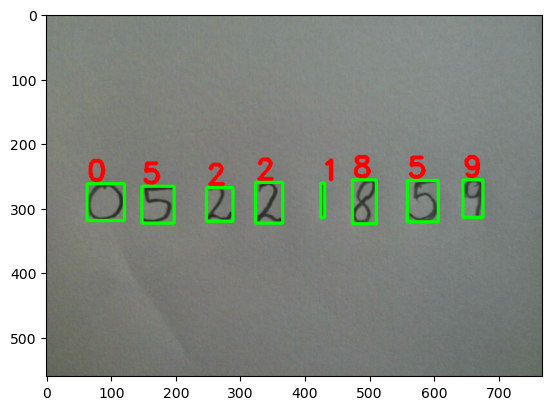

In [32]:
#detect_digits("/content/drive/MyDrive/DeepLearningAtelier-E3FD/TP4/data/photo1.jpg", model)  # Change for your path
detect_digits("./data/photo1.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


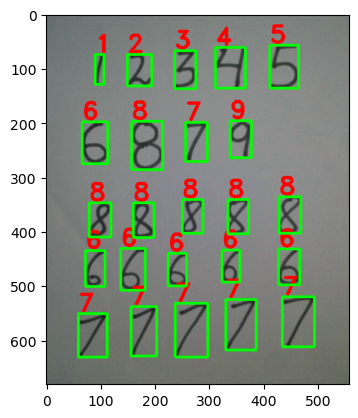

In [33]:
# detect_digits("/content/drive/MyDrive/DeepLearningAtelier-E3FD/TP4/data/photo2.jpg", model)  # Change for your path
detect_digits("./data/photo2.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


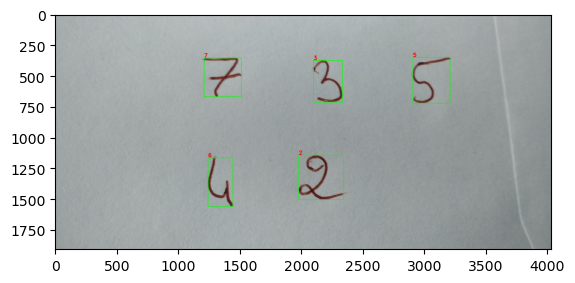

In [34]:
# detect_digits("/content/drive/MyDrive/DeepLearningAtelier-E3FD/TP4/data/photo3.jpg", model)  # Change for your path
detect_digits("./data/photo3.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


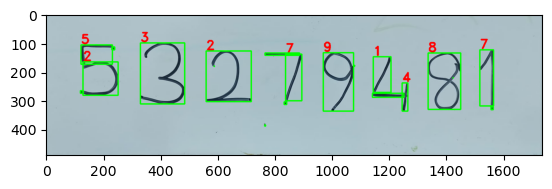

In [35]:
# detect_digits("/content/drive/MyDrive/DeepLearningAtelier-E3FD/TP4/data/mynumbers.jpeg", model)  # Change for your path
detect_digits("./data/mynumbers.jpeg", model)

# 2. Other CNN hyperparameters (Padding, Stride)¶

#### 2.1 Padding
Padding is used in convolutional layers to control the spatial dimensions of the output feature map. There are three main types of padding: **'valid'**, **'same'**, and **manual padding**.

##### a) `padding='valid'` (No Padding)
* **No extra padding is added** to the input.

* As a result, the output size shrinks after each convolution.

* This is the **default padding** setting in most deep learning frameworks (e.g. Keras, TensorFlow), even if we do explicitly specify it.

* Formula (for width, similarly applies for height):
  $$
    W_o = \left\lfloor \frac{W_i - F}{S} + 1   \right\rfloor
  $$
where
  * $W_o$ = output width
  * $W_i$ = input width
  * $F$ = kernel (filter) size
  * $S$ = stride step

##### b) `padding='same'` (Zero Padding to Maintain Size)
* **Zero-padding is added** so that the output size remains the **same** as the input size.

* Padding is applied symmetrically on both sides of the input so that the output feature map has the same spatial dimensions as the input (except when the kernel size does not perfectly divide the input size, in which case, the output size will be slightly smaller in one dimension).

* When padding='same', the **exact padding value** is **not explicitly given**, but is automatically calculated based on the kernel size.

* Formula for padding *P* for a given kernel size:
  $$
  P = \left\lfloor \frac{F - 1}{2}  \right\rfloor
  $$

* **Example:**
  * For a kernel size of (3,3): $ P = (3-1)/2 = 1 $  . Thus, 1 pixel will be added to the top, bottom, left, and right of the input to keep the output size the same as the input.
  * For a kernel size of (2,2): $ P = (2-1)/2 = 0 $  , which means no padding is applied.

* **Key point:** This padding is particularly useful when we want to preserve the spatial dimensions of the input throughout the network.

##### c) `padding=(padding_height, padding_width)` (Manually Specified Padding)
* **Custom padding** can be specified if you need to define specific padding values instead of using 'valid' or 'same'.

* This is useful when you have specific requirements for how much padding to apply, such as padding more on one side.
  
* The [`ZeroPadding2D`](https://keras.io/api/layers/reshaping_layers/zero_padding2d/) layer allows for custom padding values.

* Formula with manual padding (for width, similarly applies for height) :
  $$
    W_o = \left\lfloor \frac{W_i - F + 2*P}{S} + 1   \right\rfloor
  $$
  
* **Example:** If $P$ = (2,2), then 2 pixels are added to the top, bottom, left, and right of the input.


In [38]:
def cnn_padding(input_dim):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=input_dim) )
    model.add(layers.MaxPooling2D((2, 2)) )
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu') )
    model.add(layers.MaxPooling2D((2, 2)) )
    model.add(layers.ZeroPadding2D(padding=(2,1)) )
    model.add(layers.Conv2D(64, (3, 3), activation='relu') )
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

model_padding = cnn_padding(input_dim = (28, 28, 1))
model_padding.summary()

C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 10, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         196,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,066 (988.54 KB)

 Trainable params: 253,066 (988.54 KB)

 Non-trainable params: 0 (0.00 B)

#### 2.2 Stride
Stride controls the step size at which the filter (kernel) moves across the input image during convolution or pooling operations. It determines how much the filter (kernel) shifts at each step.

* **`strides` is 1:**
  * The filter moves one pixel at a time.
  * This results in dense feature maps because the filter overlaps more of the input, preserving more spatial information.
  * Default stride value for convolutional layer in most frameworks (e.g. Keras, TensorFlow).

* **`strides` is 2:**
  * The filter moves two pixels at a time.
  * This causes the output size to reduce faster since fewer positions are available for the filter to move.
  * This is often used to downsample the input, reducing the spatial dimensions more quickly.
  
* **Stride in Convolution and Pooling:**
  * Stride can be applied in both convolutional layers (to extract features) and pooling layers (to downsample the input).
  * In pooling, larger strides lead to more aggressive downsampling, which helps reduce the spatial dimensions of the input.
    * Default stride value for pooling layer is same as kernel size of pooling layer in most frameworks (e.g. Keras, TensorFlow).


* Formula with stride in convolutional layer is already given above, see 2.1 Padding.
  
* Formula with stride in pooling layer (for width, similarly applies for height):
  $$
    W_o = \left\lfloor \frac{W_i - F}{S} + 1   \right\rfloor
  $$

In [40]:
def cnn_stride(input_dim):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=input_dim) )
    model.add(layers.MaxPooling2D((2, 2), strides=2) )
    model.add(layers.Conv2D(64, (3, 3), strides=1, activation='relu') )
    model.add(layers.MaxPooling2D((2, 2)) )
    model.add(layers.Conv2D(64, (3, 3), strides=2, activation='relu') )
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

model_stride = cnn_stride(input_dim = (28, 28, 1))
model_stride.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,842 (284.54 KB)

 Trainable params: 72,842 (284.54 KB)

 Non-trainable params: 0 (0.00 B)

## ===== Exercise 2 =====

Add the following hyperparameters for padding and stride into the function `cnn_padding_stride`.

* First convolution layer with **no padding** and **S = 1** (which is already the default value for strides)
* First pooling layer with **S = 2**
* Second convolution layer with **padding = (2, 2)** and **S = 1**
* Second pooling layer with **S = 2**
* Third convolution layer with **padding = 'same'** and **S = 2**

Note that our first CNN model has already a very good test accuracy (i.e. 99%). However, we just try to use padding and strides to learn their implementations on the model.

In [42]:
def cnn_padding_stride(input_dim):

    model = models.Sequential()    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', strides=1, input_shape=input_dim))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.ZeroPadding2D(padding=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=1))
    model.add(layers.MaxPooling2D((2, 2), strides=1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

model_full = cnn_padding_stride(input_dim = (28, 28, 1))
model_full.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,162 (1004.54 KB)

 Trainable params: 257,162 (1004.54 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_full.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_full.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.8836 - loss: 0.3782
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.9856 - loss: 0.0479
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.9904 - loss: 0.0303
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.9912 - loss: 0.0268
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.9939 - loss: 0.0188


In [44]:
test_loss, test_acc = model_full.evaluate(test_images, test_labels)

print("Test accuracy after padding and stride:", test_acc*100, "%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9862 - loss: 0.0425
Test accuracy after padding and stride: 98.96000027656555 %


Call `detect_digits` function to apply this model with padding and stride on your own handwritten digits.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


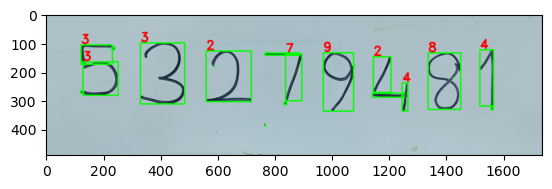

In [46]:
# detect_digits("/content/drive/MyDrive/DeepLearningAtelier-E3FD/TP4/data/mynumbers.jpeg", model_full)  # Change for your path
detect_digits("./data/mynumbers.jpeg", model_full) 

# 3. Conclusion

In this notebook, we explored the fundamental principles of convolutional neural networks (CNNs) and their application to image processing tasks.

* Through a practical implementation on handwritten digit recognition, we demonstrated how to design, train, and evaluate CNN models effectively.

* Padding and stride are essential hyperparameters in convolutional layers, as they control the spatial dimensions of feature maps.
  